In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import json
import os

# Define the base path to the dataset
BASE_PATH = '/kaggle/input/pix3d-dataset/'

# Path to the JSON file
json_path = os.path.join(BASE_PATH, 'pix3d.json')  # Replace 'data.json' with your JSON file name

# Load the JSON data
with open(json_path, 'r') as f:
    data = json.load(f)

# Display the first entry to verify
print(data[0])


{'img': 'img/bed/0001.png', 'category': 'bed', 'img_size': [395, 244], '2d_keypoints': [[[182.5, 147.09375], [174.5, 225.09375], [16.5, 111.09375], [-1.0, -1.0], [-1.0, -1.0], [324.5, 101.09375], [336.5, 51.09375], [226.5, 20.09375], [-1.0, -1.0], [352.5, 121.09375]], [[181.5, 165.09375], [181.5, 224.09375], [3.5, 112.09375], [5.5, 141.09375], [-1.0, -1.0], [352.5, 90.09375], [349.5, 34.09375], [196.5, 26.09375], [-1.0, -1.0], [346.5, 114.09375]], [[171.5, 139.09375], [175.5, 227.09375], [29.5, 90.09375], [-1.0, -1.0], [-1.0, -1.0], [340.5, 80.09375], [351.5, 32.09375], [198.5, 22.09375], [-1.0, -1.0], [268.5, 79.09375]]], 'mask': 'mask/bed/0001.png', 'img_source': 'ikea', 'model': 'model/bed/IKEA_MALM_2/model.obj', 'model_raw': None, 'model_source': 'ikea', '3d_keypoints': 'model/bed/IKEA_MALM_2/3d_keypoints.txt', 'voxel': 'model/bed/IKEA_MALM_2/voxel.mat', 'rot_mat': [[0.7813941591465821, 0.00095539348511137, -0.6240370624208909], [0.17456672296585038, 0.9597407704535225, 0.220054794

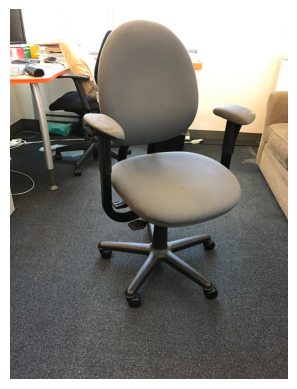

In [2]:
import cv2
import matplotlib.pyplot as plt

# Example: Load and display the first image using OpenCV
first_image_path = os.path.join(BASE_PATH, data[1500]['img'])
image = cv2.imread(first_image_path)
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()


In [3]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 6.0 MB/s eta 0:00:0000:0100:01


In [4]:
import trimesh

first_model_path = os.path.join(BASE_PATH, data[1500]['model'])
model = trimesh.load(first_model_path)

# Print model information
model.show()

In [5]:
import scipy.io
import os

# Example path to voxel file
voxel_path = os.path.join(BASE_PATH, data[1500]['voxel'])  # Adjust the path as needed

# Load the .mat file
voxel_data = scipy.io.loadmat(voxel_path)

# Check the keys of the .mat file
print(voxel_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'voxel'])


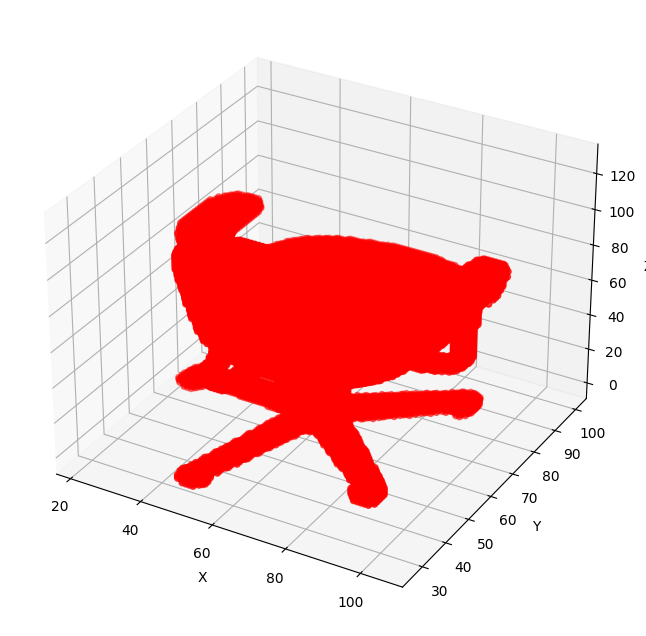

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'voxel_grid' is the key containing voxel data in the .mat file
# and voxel_data['voxel_grid'] is a 3D binary array (1 for occupied voxel, 0 for empty)
voxel_grid = voxel_data['voxel']

# Get the voxel coordinates
x, y, z = np.where(voxel_grid == 1)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot voxels
ax.scatter(x, y, z, zdir='z', c='red', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [29]:
from scipy.ndimage import zoom

# Define the target voxel size
target_voxel_size = 64  # Desired voxel grid size (e.g., 64x64x64)

# Calculate the zoom factor for each dimension
zoom_factors = [target_voxel_size / dim for dim in voxel_grid.shape]

print(f"Zoom factors for downsampling: {zoom_factors}")

# Perform downsampling using nearest-neighbor interpolation (order=0)
downsampled_voxel = zoom(voxel_grid, zoom=zoom_factors, order=0)

print(f"Downsampled voxel grid shape: {downsampled_voxel.shape}")


Zoom factors for downsampling: [0.5, 0.5, 0.5]
Downsampled voxel grid shape: (64, 64, 64)


In [30]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision



class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()


        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=3),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU(),
            #torch.nn.MaxPool2d(kernel_size=4)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        # print(rendering_images.size())  # torch.Size([batch_size, n_views, img_c, img_h, img_w])
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            #print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer1(features)
           # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer2(features)
          #  print(features.size())    # torch.Size([batch_size, 256, 6, 6])
            features = self.layer3(features)
         #   print(features.size())    # torch.Size([batch_size, 128, 4, 4])
            image_features.append(features)

        image_features = torch.stack(image_features).permute(0, 1, 2, 3, 4).contiguous()
        #print(image_features.size())  # torch.Size([batch_size, n_views, 128, 4, 4])
        return image_features



In [43]:
class Decoder(torch.nn.Module):
    def __init__(self, ):
        super(Decoder, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_voxels = []
        raw_features = []

        for features in image_features:
            gen_voxel = features.view(-1, 256, 2, 2, 2)
            # print(gen_voxel.size())   # torch.Size([batch_size, 256, 2, 2, 2])
            gen_voxel = self.layer1(gen_voxel)
            # print(gen_voxel.size())   # torch.Size([batch_size, 128, 4, 4, 4])
            gen_voxel = self.layer2(gen_voxel)
            # print(gen_voxel.size())   # torch.Size([batch_size, 64, 8, 8, 8])
            gen_voxel = self.layer3(gen_voxel)
            # print(gen_voxel.size())   # torch.Size([batch_size, 32, 16, 16, 16])
            gen_voxel = self.layer4(gen_voxel)
            # print(gen_voxel.size())   # torch.Size([batch_size, 8, 32, 32, 32])
            raw_feature = gen_voxel
            gen_voxel = self.layer5(gen_voxel)
            # print(gen_voxel.size())   # torch.Size([batch_size, 1, 32, 32, 32])
            raw_feature = torch.cat((raw_feature, gen_voxel), dim=1)
            # print(raw_feature.size()) # torch.Size([batch_size, 9, 32, 32, 32])

            gen_voxels.append(torch.squeeze(gen_voxel, dim=1))
            raw_features.append(raw_feature)

        gen_voxels = torch.stack(gen_voxels).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        #print(gen_voxels.size())        # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(raw_features.size())      # torch.Size([batch_size, n_views, 9, 32, 32, 32])
        return raw_features, gen_voxels


In [63]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

# Assume you have a custom dataset
class Pix3DDataset(Dataset):
    def __init__(self, data, base_path, transform=None, target_voxel_size=32):
        self.data = data
        self.base_path = base_path
        self.transform = transform
        self.voxel_size = target_voxel_size
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.data[idx]['img'])
        voxel_path = os.path.join(self.base_path, self.data[idx]['voxel'])
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        voxel_data = scipy.io.loadmat(voxel_path)  # Convert to voxel grid
        voxel = voxel_data["voxel"]
        zoom_factors = [self.voxel_size / dim for dim in voxel.shape]
        voxel = zoom(voxel, zoom=zoom_factors, order=0)
        voxel = torch.tensor(voxel, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        
        return image, voxel

In [64]:
def init_weights(m):
    if type(m) == torch.nn.Conv2d or type(m) == torch.nn.Conv3d or type(m) == torch.nn.ConvTranspose3d:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.BatchNorm2d or type(m) == torch.nn.BatchNorm3d:
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)
    elif type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, 0, 0.01)
        torch.nn.init.constant_(m.bias, 0)

In [65]:
# Initialize dataset and dataloader
from torchvision import transforms

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Initialize dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Pix3DDataset(data, BASE_PATH, transform=transform, target_voxel_size=32)

# Split dataset into train and test (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the encoder and decoder models
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [66]:
encoder.apply(init_weights)
decoder.apply(init_weights)

Decoder(
  (layer1): Sequential(
    (0): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): Conv

In [67]:
encoder_solver = torch.optim.Adam(filter(lambda p: p.requires_grad, encoder.parameters()),
                                          lr=1e-3,
                                          betas=(.9, .999))
decoder_solver = torch.optim.Adam(decoder.parameters(),
                                          lr=1e-3,
                                          betas=(.9, .999))

In [68]:
encoder_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(encoder_solver,
                                                                milestones=[150],
                                                                gamma=0.5)
decoder_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(decoder_solver,
                                                                milestones=[150],
                                                                gamma=0.5)

In [69]:
if torch.cuda.is_available():
        encoder = torch.nn.DataParallel(encoder).cuda()
        decoder = torch.nn.DataParallel(decoder).cuda()

In [70]:
bce_loss = torch.nn.BCELoss()

In [71]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

[INFO] 2024-10-04 07:19:53.939725 Epoch [1/50] EpochTime = 371.107 (s) EDLoss = 2.1979


[INFO] 2024-10-04 07:25:59.238208 Epoch [2/50] EpochTime = 365.198 (s) EDLoss = 1.8982


[INFO] 2024-10-04 07:32:03.902687 Epoch [3/50] EpochTime = 364.565 (s) EDLoss = 1.6427


[INFO] 2024-10-04 07:38:07.601778 Epoch [4/50] EpochTime = 363.592 (s) EDLoss = 1.4293


[INFO] 2024-10-04 07:44:10.509621 Epoch [5/50] EpochTime = 362.805 (s) EDLoss = 1.2657


[INFO] 2024-10-04 07:50:15.963638 Epoch [6/50] EpochTime = 365.351 (s) EDLoss = 1.1043


[INFO] 2024-10-04 07:56:23.694101 Epoch [7/50] EpochTime = 367.630 (s) EDLoss = 0.9601


[INFO] 2024-10-04 08:02:31.014087 Epoch [8/50] EpochTime = 367.218 (s) EDLoss = 0.8310


[INFO] 2024-10-04 08:08:38.779014 Epoch [9/50] EpochTime = 367.663 (s) EDLoss = 0.7258


[INFO] 2024-10-04 08:14:48.043963 Epoch [10/50] EpochTime = 369.165 (s) EDLoss = 0.6416


[INFO] 2024-10-04 08:20:53.857887 Epoch [11/50] EpochTime = 365.708 (s) EDLoss = 0.5671


[INFO] 2024-10-04 08:27:01.865425 Epoch [12/50] EpochTime = 367.906 (s) EDLoss = 0.5047


[INFO] 2024-10-04 08:39:22.631602 Epoch [14/50] EpochTime = 372.216 (s) EDLoss = 0.4041


[INFO] 2024-10-04 08:45:32.063507 Epoch [15/50] EpochTime = 369.314 (s) EDLoss = 0.3685


[INFO] 2024-10-04 08:51:41.057142 Epoch [16/50] EpochTime = 368.891 (s) EDLoss = 0.3395


[INFO] 2024-10-04 08:57:49.821462 Epoch [17/50] EpochTime = 368.659 (s) EDLoss = 0.3069


[INFO] 2024-10-04 09:03:42.557932 Epoch [18/50] EpochTime = 352.637 (s) EDLoss = 0.2834


[INFO] 2024-10-04 09:08:57.321244 Epoch [19/50] EpochTime = 314.660 (s) EDLoss = 0.2635


[INFO] 2024-10-04 09:14:10.525025 Epoch [20/50] EpochTime = 313.100 (s) EDLoss = 0.2463


[INFO] 2024-10-04 09:19:21.936796 Epoch [21/50] EpochTime = 311.306 (s) EDLoss = 0.2292


[INFO] 2024-10-04 09:24:33.124763 Epoch [22/50] EpochTime = 311.087 (s) EDLoss = 0.2155


[INFO] 2024-10-04 09:29:44.994762 Epoch [23/50] EpochTime = 311.766 (s) EDLoss = 0.2053


[INFO] 2024-10-04 09:34:56.029904 Epoch [24/50] EpochTime = 310.935 (s) EDLoss = 0.1887


[INFO] 2024-10-04 09:40:07.247335 Epoch [25/50] EpochTime = 311.116 (s) EDLoss = 0.1783


[INFO] 2024-10-04 09:45:20.691961 Epoch [26/50] EpochTime = 313.341 (s) EDLoss = 0.1668


[INFO] 2024-10-04 09:50:30.439234 Epoch [27/50] EpochTime = 309.641 (s) EDLoss = 0.1586


[INFO] 2024-10-04 09:55:38.970745 Epoch [28/50] EpochTime = 308.428 (s) EDLoss = 0.1537


[INFO] 2024-10-04 10:00:47.559087 Epoch [29/50] EpochTime = 308.488 (s) EDLoss = 0.1498


[INFO] 2024-10-04 10:05:55.979348 Epoch [30/50] EpochTime = 308.318 (s) EDLoss = 0.1421


[INFO] 2024-10-04 10:11:05.123216 Epoch [31/50] EpochTime = 309.042 (s) EDLoss = 0.1342


[INFO] 2024-10-04 10:16:14.974974 Epoch [32/50] EpochTime = 309.748 (s) EDLoss = 0.1311


[INFO] 2024-10-04 10:21:25.112694 Epoch [33/50] EpochTime = 310.036 (s) EDLoss = 0.1397


[INFO] 2024-10-04 10:26:36.649738 Epoch [34/50] EpochTime = 311.424 (s) EDLoss = 0.1554


[INFO] 2024-10-04 10:31:48.305111 Epoch [35/50] EpochTime = 311.552 (s) EDLoss = 0.1483


[INFO] 2024-10-04 10:37:01.182917 Epoch [36/50] EpochTime = 312.777 (s) EDLoss = 0.1491


[INFO] 2024-10-04 10:42:14.582825 Epoch [37/50] EpochTime = 313.298 (s) EDLoss = 0.1272


[INFO] 2024-10-04 10:47:29.348467 Epoch [38/50] EpochTime = 314.661 (s) EDLoss = 0.1031


[INFO] 2024-10-04 10:52:41.258739 Epoch [39/50] EpochTime = 311.810 (s) EDLoss = 0.0899


[INFO] 2024-10-04 10:57:53.764251 Epoch [40/50] EpochTime = 312.403 (s) EDLoss = 0.0835


[INFO] 2024-10-04 11:03:05.596666 Epoch [41/50] EpochTime = 311.727 (s) EDLoss = 0.0799


[INFO] 2024-10-04 11:08:17.592917 Epoch [42/50] EpochTime = 311.893 (s) EDLoss = 0.0780


[INFO] 2024-10-04 11:13:30.295036 Epoch [43/50] EpochTime = 312.598 (s) EDLoss = 0.0752


[INFO] 2024-10-04 11:18:44.666422 Epoch [44/50] EpochTime = 314.269 (s) EDLoss = 0.0744


[INFO] 2024-10-04 11:24:00.076873 Epoch [45/50] EpochTime = 315.309 (s) EDLoss = 0.0725


[INFO] 2024-10-04 11:29:12.984301 Epoch [46/50] EpochTime = 312.803 (s) EDLoss = 0.0705


[INFO] 2024-10-04 11:34:25.497790 Epoch [47/50] EpochTime = 312.411 (s) EDLoss = 0.0699


[INFO] 2024-10-04 11:39:37.730556 Epoch [48/50] EpochTime = 312.130 (s) EDLoss = 0.0718


[INFO] 2024-10-04 11:44:49.021460 Epoch [49/50] EpochTime = 311.189 (s) EDLoss = 0.0719


[INFO] 2024-10-04 11:50:01.922970 Epoch [50/50] EpochTime = 312.799 (s) EDLoss = 0.0720


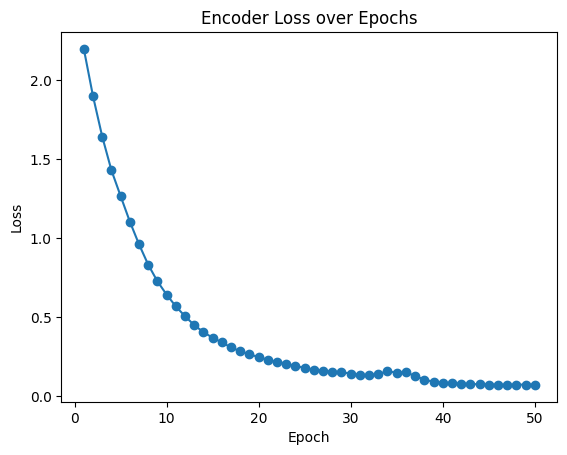

In [73]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from datetime import datetime as dt

# To store the encoder loss for each epoch
epoch_losses = []
epochs = 50
# Training loop
for epoch_idx in range(0, epochs):
    # Start time for the epoch
    epoch_start_time = time()

    # Batch average metrics
    batch_time = AverageMeter()
    data_time = AverageMeter()
    encoder_losses = AverageMeter()

    # Switch models to training mode
    encoder.train()
    decoder.train()

    batch_end_time = time()
    n_batches = len(train_loader)  # Use train_loader

    # Initialize the progress bar for the current epoch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_idx+1}/{epochs}", leave=False)

    for batch_idx, (images, voxels) in enumerate(progress_bar):
        images = images.to(device)
        voxels = voxels.to(device)
        
        # Measure data loading time
        #data_time.update(time() - batch_end_time)
        
        # Forward pass
        images = images.unsqueeze(0)
        image_features = encoder(images)
        raw_features, generated_volumes = decoder(image_features)

        # Compute loss
        encoder_loss = bce_loss(generated_volumes, voxels) * 10

        # Zero out gradients, backpropagate, and update weights
        encoder.zero_grad()
        decoder.zero_grad()
        encoder_loss.backward()
        encoder_solver.step()
        decoder_solver.step()

        # Update loss and time metrics
        encoder_losses.update(encoder_loss.item())
#         batch_time.update(time() - batch_end_time)
#         batch_end_time = time()

        # Update progress bar
        progress_bar.set_postfix({
            'EDLoss': encoder_loss.item()
        })

        # Step the learning rate schedulers
        encoder_lr_scheduler.step()
        decoder_lr_scheduler.step()

    # Record the average loss for this epoch
    epoch_losses.append(encoder_losses.avg)

    # End of epoch
    epoch_end_time = time()
    print(f'[INFO] {dt.now()} Epoch [{epoch_idx+1}/{epochs}] EpochTime = {epoch_end_time - epoch_start_time:.3f} (s) EDLoss = {encoder_losses.avg:.4f}')

    # Save the model after each epoch
    torch.save({
        'epoch': epoch_idx + 1,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'encoder_optimizer_state_dict': encoder_solver.state_dict(),
        'decoder_optimizer_state_dict': decoder_solver.state_dict(),
        'loss': encoder_losses.avg
    }, f"model_epoch_{epoch_idx+1}.pth")

# After training, plot the loss history
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Encoder Loss over Epochs')
plt.show()


In [118]:
import torch
import torch.nn.functional as F

# Function to calculate IoU
def calculate_iou(predictions, targets, threshold=0.5):
    """
    Calculate the Intersection over Union (IoU) between predictions and targets.
    Args:
        predictions (torch.Tensor): Predicted volumes.
        targets (torch.Tensor): Ground truth voxels.
        threshold (float): Threshold for binarizing predictions.
    Returns:
        float: IoU score.
    """
    # Binarize predictions
    pred_binary = (predictions > threshold).float()
    target_binary = targets.float()

    # Calculate intersection and union
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection

    # Avoid division by zero
    if union == 0:
        return 0.0

    iou = intersection / union
    return iou.item()

# Load the saved model checkpoint
checkpoint = torch.load("/kaggle/working/model_epoch_50.pth")

# Initialize the encoder and decoder models
# encoder = Encoder()  # Use the same architecture as your training
# decoder = Decoder()
# if torch.cuda.is_available():
#     encoder = torch.nn.DataParallel(encoder).cuda()
#     decoder = torch.nn.DataParallel(decoder).cuda()

# Load the state dicts (weights) into the models
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Put the models into evaluation mode
encoder.eval()
decoder.eval()

# Disable gradient calculation for inference/testing
with torch.no_grad():
    total_loss = 0.0
    total_iou = 0.0
    num_batches = 0

    for batch_idx, (images, voxels) in enumerate(test_loader):
        images = images.to(device)
        voxels = voxels.to(device)

        # If the images need reshaping
        images = images.unsqueeze(0)  # Add batch dimension if required

        # Pass the images through the model
        image_features = encoder(images)
        raw_features, generated_volumes = decoder(image_features)
        generated_volume = generated_volumes.squeeze(1) 
        print(generated_volume.shape)
        # Compute the loss between generated volumes and actual voxels
        encoder_loss = bce_loss(generated_volumes, voxels) * 10

        # Calculate IoU
        iou = calculate_iou(generated_volumes, voxels)

        total_loss += encoder_loss.item()
        total_iou += iou
        num_batches += 1

        print(f"[Batch {batch_idx + 1}] Loss: {encoder_loss.item()}, IoU: {iou}")
        

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_iou = total_iou / num_batches if num_batches > 0 else 0
    print(f"Average Test Loss: {avg_loss}")
    print(f"Average Test IoU: {avg_iou}")


/tmp/ipykernel_30/172228269.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/model_epoch_50.pth")


torch.Size([64, 32, 32, 32])
[Batch 1] Loss: 3.9402947425842285, IoU: 0.13174057006835938
torch.Size([64, 32, 32, 32])
[Batch 2] Loss: 5.672503471374512, IoU: 0.08903615176677704
torch.Size([64, 32, 32, 32])
[Batch 3] Loss: 6.229856014251709, IoU: 0.16048327088356018
torch.Size([64, 32, 32, 32])
[Batch 4] Loss: 5.180141448974609, IoU: 0.11798624694347382
torch.Size([64, 32, 32, 32])
[Batch 5] Loss: 4.273746490478516, IoU: 0.1314900815486908
torch.Size([64, 32, 32, 32])
[Batch 6] Loss: 5.6568098068237305, IoU: 0.09880509227514267
torch.Size([64, 32, 32, 32])
[Batch 7] Loss: 6.468819618225098, IoU: 0.13874948024749756
torch.Size([64, 32, 32, 32])
[Batch 8] Loss: 6.945405960083008, IoU: 0.1337566077709198
torch.Size([64, 32, 32, 32])
[Batch 9] Loss: 5.619569778442383, IoU: 0.1604425460100174
torch.Size([64, 32, 32, 32])
[Batch 10] Loss: 5.609764099121094, IoU: 0.1544174700975418
torch.Size([64, 32, 32, 32])
[Batch 11] Loss: 6.467295169830322, IoU: 0.16044723987579346
torch.Size([64, 32, 3

In [20]:
from tqdm import tqdm

# Training Loop with tqdm progress bar
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Use tqdm to wrap the dataloader for progress tracking
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, voxels in progress_bar:
        images = images.to(device)
        voxels = voxels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, voxels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/2:  31%|███▏      | 1051/3357 [04:30<10:00,  3.84it/s, loss=0.243] /opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/2, Loss: 0.2033


Epoch 2/2, Loss: 0.1817


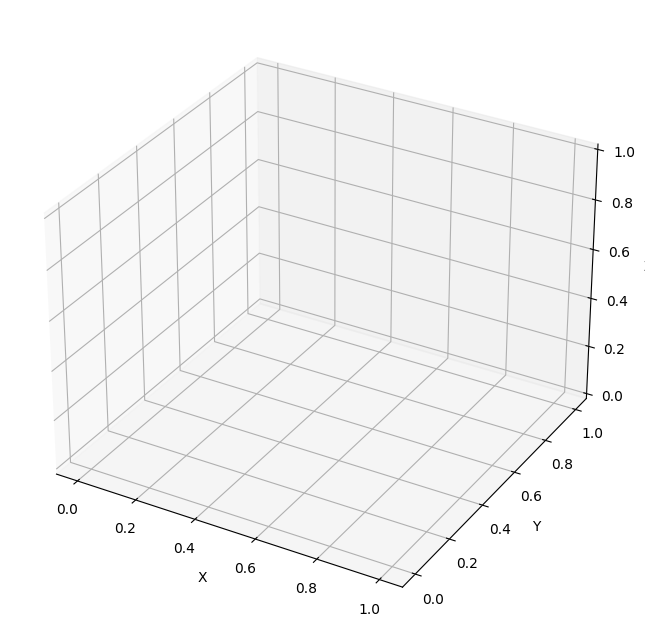

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_voxel(voxel_grid):
    voxel_grid = voxel_grid.squeeze().cpu().detach().numpy()
    x, y, z = np.where(voxel_grid == 1)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, zdir='z', c='red', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# # Get a sample from the test set
# model.eval()
# with torch.no_grad():
#     sample_image, sample_voxel = next(iter(dataloader))
#     sample_image = sample_image.to(device)
#     generated_voxel = model(sample_image)
#     visualize_voxel(generated_voxel[2])
# generated_voxel
visualize_voxel(generated_volume[1])

In [21]:
# Save the model after training
torch.save(model.state_dict(), "voxel_reconstruction_model.pth")
print("Model weights saved.")

Model weights saved.
